# Custom distribution
Experiment with `DensityDist`

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np
import scipy
import theano
import theano.tensor as tt

import pymc3 as pm

In [2]:
"""def normal_logp(mu, sd):
    def _logp(x):
        return tt.log(1/(tt.exp((x - mu)**2/(2*sd**2))*(tt.sqrt(2*np.pi)*sd)))
    return _logp"""

'def normal_logp(mu, sd):\n    def _logp(x):\n        return tt.log(1/(tt.exp((x - mu)**2/(2*sd**2))*(tt.sqrt(2*np.pi)*sd)))\n    return _logp'

In [3]:
from pymc3.distributions.distribution import generate_samples, draw_values

In [4]:
"""def normal_rng(mu, sd, point=None, size=None):
    # draw a numerical value for the parameters
    mu_, sd_ = draw_values([mu, sd], point=point)
    
    size = 1 if size is None else size
    
    return generate_samples(scipy.stats.norm.rvs, loc=mu_, scale=sd_, size=size, broadcast_shape=(size,))"""

'def normal_rng(mu, sd, point=None, size=None):\n    # draw a numerical value for the parameters\n    mu_, sd_ = draw_values([mu, sd], point=point)\n    \n    size = 1 if size is None else size\n    \n    return generate_samples(scipy.stats.norm.rvs, loc=mu_, scale=sd_, size=size, broadcast_shape=(size,))'

In [5]:
# Test if the generate function workd properly. What is `dist_shape`?
generate_samples(scipy.stats.norm.rvs, loc=0, scale=1, size=10, broadcast_shape=(10,))
#generate_samples(scipy.stats.norm.rvs, loc=0, scale=1, size=10, dist_shape=10)

array([-0.78572666,  0.63474722, -0.44091072,  0.25673397,  0.73303017,
        1.00585064,  1.08555294, -2.60241315,  0.14505996, -0.88163944])

In [6]:
# generate observations
np.random.seed(23)
y = np.random.normal(loc=0.0, scale=1.0, size=100)

In [7]:
with pm.Model() as model:
    
    mu = pm.Normal('mu', mu=0, sd=10)
    sd = pm.HalfNormal('sd', sd=10)
    
    def normal_logp(value):
        #return tt.log(1/(tt.exp((value - mu)**2/(2*sd**2))*(tt.sqrt(2*np.pi)*sd)))
        # Obtained from Mathematica: 
        # FullSimplify[LogLikelihood[NormalDistribution[\[Mu], \[Sigma]], {x}], {\[Sigma] > 0, Element[{\[Sigma], \[Mu], x}, Reals]} ]
        return (1/2)*(-((value - mu)**2/sd**2) - tt.log(2*np.pi) - 2*tt.log(sd))
        
    def normal_rng(point=None, size=None):
        # draw a numerical value for the parameters
        mu_, sd_ = draw_values([mu, sd], point=point)
        size = 1 if size is None else size
        
        return generate_samples(scipy.stats.norm.rvs, loc=mu_, scale=sd_, size=size, dist_shape=y.shape)
    
    likelihood = pm.DensityDist('likelihood', normal_logp, observed=y, random=normal_rng)

In [8]:
model.check_test_point()

mu             -3.22
sd_log__       -0.77
likelihood   -300.29
Name: Log-probability of test_point, dtype: float64

In [9]:
CHAINS = 2
CORES = 1
with model:
    trace = pm.sample(draws=1000, tune=1000, chains=CHAINS, cores=CORES, random_seed=[23+ i for i in np.arange(CHAINS)])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, mu]
100%|███████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 860.96it/s]
C:\Miniconda3\envs\intro_to_pymc3\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


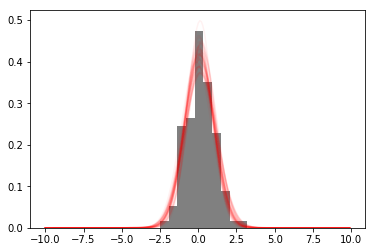

In [10]:
x = np.arange(-10, 10, 0.1)

THIN = 50

plt.hist(y, density=True, facecolor='gray')

for mu, sd in zip(trace['mu'][::THIN], trace['sd'][::THIN]):
    pdf = scipy.stats.norm.pdf(x, loc=mu, scale=sd)
    plt.plot(x, pdf, color='red', alpha=0.05)

In [11]:
with model:
    #ppc = pm.sample_posterior_predictive(trace, samples=250, size=100)
    ppc = pm.sample_posterior_predictive(trace)
    
ppc['likelihood'].shape

100%|██████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3558.74it/s]


(1000, 100)

C:\Miniconda3\envs\intro_to_pymc3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


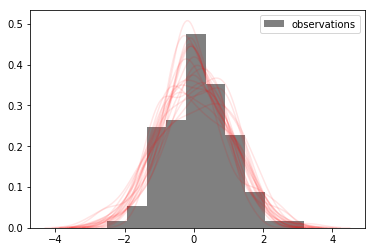

In [12]:
plt.hist(y, density=True, facecolor='gray', label='observations')
#plt.hist(ppc['likelihood'].flatten(), histtype='step', density=True, label='ppc');
for row in ppc['likelihood'][::THIN]:
    sns.kdeplot(row, color='red', alpha=0.1)
plt.legend()
pass